In [2]:
import numpy as np

In [3]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import widgets

In [4]:
import torch 
import torch.nn as nn

In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="4"
device = torch.device("cuda")
print(device)
import matplotlib.pyplot as plt
from tqdm import tqdm

cuda


In [6]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [28]:
import torch.nn.functional as F 

class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, num_layers, dropout_rate = 0):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.linear = nn.Linear(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            dropout = dropout_rate, batch_first = True)
        
    def forward(self, x):
        x = F.relu(self.linear(x))
        outputs, hidden = self.lstm(x)
        return outputs, hidden
    
    
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, dropout_rate = 0):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.lstm = nn.LSTM(output_dim, hidden_dim, num_layers = num_layers, 
                            dropout = dropout_rate, batch_first = True)
        
        self.out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, hidden):
        output, hidden = self.lstm(x, hidden)   
        prediction = self.out(output.float())
        return prediction, hidden   

class Seq2Seq(nn.Module):
    def __init__(self, input_dim, embedding_dim, output_dim, hidden_dim, num_layers):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_dim = input_dim, embedding_dim = embedding_dim, hidden_dim = hidden_dim, num_layers = num_layers).to(device)
        self.decoder = Decoder(output_dim = output_dim, hidden_dim = hidden_dim, num_layers = num_layers).to(device)
        self.output_dim = output_dim
            
    def forward(self, x, target_length):
        batch_size = x.size(0) 
        input_length = x.size(2) 
        x = x.permute(0, 2, 1, 3)
        x = x.reshape((batch_size, input_length, -1))
        
        output_dim = self.decoder.output_dim
        encoder_output, encoder_hidden = self.encoder(x)

        decoder_output = torch.zeros((batch_size, 1, output_dim), device = device)
        decoder_hidden = encoder_hidden
        
        outputs = []
        for t in range(target_length):  
            decoder_output, decoder_hidden = self.decoder(decoder_output, decoder_hidden)
            outputs.append(decoder_output)
        out = torch.cat(outputs, dim = 1) 
        out = out.reshape((batch_size, target_length, 3, -1))
        out = out.permute((0, 2, 1, 3))
        return out

In [56]:
class FC(nn.Module): 
    def __init__(self, input_dim, input_len, hidden_dim, output_dim): 
        super(FC, self).__init__()
        self.input_dim = input_dim
        self.input_len = input_len
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.fc = nn.Sequential(
            nn.Linear(input_len * input_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, output_dim) 
        )
    
    def forward(self, x, output_length): 
#         x = x.permute(0, 2, 1).float().to(device)
        x = x.reshape(x.shape[0], -1) 

        outputs = []
        for i in range(output_length): 
            out = self.fc(x)
            xx = torch.cat([x[:, self.input_dim:], out], dim = 1)  
            outputs.append(out)
#             print(out.shape)
        outputs = torch.cat(outputs, dim = 1)
        outputs = outputs.reshape((x.shape[0], 3, 12, -1))
        return outputs

In [5]:
from torchdiffeq import odeint

class Latent_ODE(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20, rhidden = 20, aug = False, aug_dim = 2):
        super(Latent_ODE, self).__init__()
        self.aug = aug
        self.aug_dim = aug_dim
        if self.aug:
            self.rec = RecognitionRNN(latent_dim, obs_dim+aug_dim, rhidden)
        else:
            self.rec = RecognitionRNN(latent_dim, obs_dim, rhidden)
    
        self.func = LatentODEfunc(latent_dim, nhidden)
        self.dec = LatentODEDecoder(latent_dim, obs_dim, nhidden)
        
    def forward(self, x, output_length):
        time_steps = torch.arange(0, output_length, 0.01).float().to(device)[:output_length] 
        batch_size = x.size(0) 
        input_length = x.size(2)
        x = x.permute(0, 2, 1, 3)
        x = x.reshape((batch_size, input_length, -1))
        if self.aug:
            aug_ten = torch.zeros(x.shape[0], x.shape[1], self.aug_dim).float().to(device)
            x = torch.cat([x, aug_ten], dim = -1)
#         print(xx.shape)
#         print(torch.flip(xx, [1]).shape)
        z0 = self.rec.forward(torch.flip(x, [1]))
        pred_z = odeint(self.func, z0, time_steps).permute(1, 0, 2)
        out = self.dec(pred_z)
#         print(out.shape)
        out = out.reshape((batch_size, output_length, 3, -1))
        out = out.permute((0, 2, 1, 3))
        return out  
    
class LatentODEfunc(nn.Module):
    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, nhidden),
            nn.ELU(),
            nn.Linear(nhidden, nhidden),
            nn.ELU(),
            nn.Linear(nhidden, nhidden),
            nn.ELU(),
            nn.Linear(nhidden, nhidden),
            nn.ELU(),
            nn.Linear(nhidden, latent_dim)
        )
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.model(x)
        return out
    
class RecognitionRNN(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.model = nn.GRU(obs_dim, nhidden, batch_first = True)
        self.linear = nn.Linear(nhidden, latent_dim)

    def forward(self, x):
        #h0 = torch.zeros(1, x.shape[0], self.nhidden).to(device)
        output, hn = self.model(x)#, h0
        return self.linear(hn[0])
    
class LatentODEDecoder(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(LatentODEDecoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, obs_dim)
        )
        
    def forward(self, z):
        out = self.model(z)
        return out 

In [44]:
class LWR_Residual(nn.Module): 
    def __init__(self, input_dim, hidden_dim, output_dim): 
        super(LWR_Residual, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, output_dim) 
        )
    
    def forward(self, x, t): 
#         x = x.permute(0, 2, 1).float().to(device)
#         x = x.reshape(x.shape[0], -1) 
        # x [120] t [3550]
        x_len = x.shape[0]
        xx, tt = torch.meshgrid(x, t)
        X = torch.vstack((np.ravel(xx), np.ravel(tt))).T
        print(X.shape)
        outputs = []
        for i in range(t): 
            out = self.fc(X[i * x_len : i * x_len + x_len, :].flatten())
            outputs.append(out)
        outputs = torch.cat(outputs, dim = 1)
        print(outputs.shape)
        outputs = outputs.reshape((3, -1, x_len))
        return outputs

In [45]:
import torch.nn.functional as F

class PiecewiseLinearModel(nn.Module):
    def __init__(self, n_breaks, num_regions):
        super(PiecewiseLinearModel, self).__init__()
        self.breaks = nn.Parameter(torch.rand((num_regions, 1, n_breaks)))
        self.linear = nn.Linear(n_breaks + 1, 1)
    def forward(self, xx): 
        if len(xx.shape) < 3: 
            xx = xx.unsqueeze(-1)
        out = torch.cat([xx, F.relu(xx - self.breaks)],2)
#         print(out.shape)
        return self.linear(out).squeeze(-1)

In [46]:
class Neural_LWR_sparse2_3cmp(nn.Module):
    def __init__(self, nx, dx, dt, kj, vf, xi, tskip, y_max, y_min, plm = True, plm_vf = True, initial='random', boundary='zeros',
                fix_vf=False, parstep=1):
        self.nx = nx
        #xi are the locations along distance where data is available
        self.xi = xi
        self.tskip = tskip 
        self.y_max = y_max 
        self.y_min = y_min
            
        super(Neural_LWR_sparse2_3cmp, self).__init__()
        
        self.cmps=["k","q","u"]  #density, flow, velocity
        self.initial={}
        self.boundary={}
        
#         if initial == 'random':
#             self.initial["u"] = torch.nn.Parameter(torch.rand(nx))
#             self.initial["k"] = torch.nn.Parameter(torch.rand(nx))
#             self.initial["q"] = self.initial["k"] * self.initial["v"]
#         elif initial == 'zeros':
#             for c in self.cmps:
#                 self.initial[c] = torch.zeros(nx, requires_grad=True).double()
#         else:
#             assert list(initial.keys()) == self.cmps, "initial conditions should be dictionary with k,q and u"
#             for c in self.cmps:
#                 self.initial[c] = torch.tensor(initial[c])
            
#         # influx at upstream border - needs to be known or assumed
#         if boundary == 'zeros':
#             for c in self.cmps:
#                 self.boundary[c] = torch.zeros(nt, requires_grad=True).double()
#         else:
#             assert list(boundary.keys()) == self.cmps, "boundary conditions should be dictionary with u,k and q"
#             for c in self.cmps:
#                 self.boundary[c] = torch.tensor(boundary[c])
            
        #factor by which parameter resolution is reduced with respect to nx
        self.parstep=parstep
        
        # use piecewise linear function for kj
        if plm == False: 
            self.kappa = torch.nn.Parameter(torch.tensor(kj[::self.parstep]), requires_grad=True)
#             print(self.kappa, self.kappa.shape)
        else: 
            self.plm = PiecewiseLinearModel(n_breaks = 2, num_regions = self.nx).to(device)
        
        #characteristic velocity vf
        if plm_vf: 
            self.plm_vf = PiecewiseLinearModel(n_breaks = 2, num_regions = self.nx).to(device)
        elif not fix_vf:
            self.vf=torch.nn.Parameter(torch.tensor(vf[::self.parstep]), requires_grad=True)
#             print(self.vf, self.vf.shape)
#             self.plm = PiecewiseLinearModel(n_breaks = 2, num_regions = self.nx, x = vf)
        else:
            self.vf=torch.tensor(vf[::self.parstep])
        
        self.dx = torch.tensor(dx)
        self.dt = torch.tensor(dt)
        
        
        self.residual = LWR_Residual(nx * 2, 512, nx * 3)
        
    def forward(self, initial, boundary, tsteps): 
#         self.cmps=["k","q","u"]  #density, flow, velocity
#         self.initial={}
#         self.boundary={}
        if initial == 'random':
            self.initial["u"] = torch.nn.Parameter(torch.rand(nx))
            self.initial["k"] = torch.nn.Parameter(torch.rand(nx))
            self.initial["q"] = self.initial["k"] * self.initial["v"]
        elif initial == 'zeros':
            for c in self.cmps:
                self.initial[c] = torch.zeros(nx, requires_grad=True).double()
        else:
            self.initial["k"] = initial[0].to(device)
            self.initial["q"] = initial[1].to(device)
            self.initial["u"] = initial[2].to(device)
            
        # influx at upstream border - needs to be known or assumed
        if boundary == 'zeros':
            for c in self.cmps:
                self.boundary[c] = torch.zeros(nt, requires_grad=True).double()
        else:
            self.boundary["k"] = boundary[0].to(device)
            self.boundary["q"] = boundary[1].to(device)
            self.boundary["u"] = boundary[2].to(device)
        
        nt=len(tsteps) 
        t = torch.linspace(0, 1, nt).repeat(self.nx, 1).to(device)
        kappa = self.plm(t).to(device)
#         vf = self.plm_vf(t).to(device)
        self.k=[self.initial["k"]]   # density
        self.u=[self.initial["u"]]   # velocity
        self.q=[self.initial["q"]]   # flow
        
        #initial values at output points
        self.ki=[self.initial["k"][self.xi]]
        self.ui=[self.initial["u"][self.xi]]
        self.qi=[self.initial["q"][self.xi]]
        
        x = torch.arange(1, nx).to(device)
        t = torch.arange(1, nt).to(device)
        res = self.residual(x, t)
        
        for n in range(1,nt):
            #This corresponds to the upwind scheme according to Gaddam et al. (2015).
            nk=torch.zeros(nx, requires_grad=True).double().to(device)
            nu=torch.zeros(nx, requires_grad=True).double().to(device)
            nq=torch.zeros(nx, requires_grad=True).double().to(device)

            #new values for 3 variables stored in one tensor per time step
            nk[0] = self.boundary["k"][n].to(device)
            nu[0] = self.boundary["u"][n].to(device)
            nq[0] = self.boundary["q"][n].to(device)
                                  
            #full-resolution tensor hkappa and hv1, from down-sampled versions
            idx=torch.arange(self.nx) / self.parstep
#             hkappa=self.kappa[idx.long()]
            hkappa = kappa[:, n - 1]
#             print(hkappa.shape)
#             print(hkappa, hkappa.shape)
#             hvf = vf[:, n - 1]
            hvf=self.vf[idx.long()]
            nk[1:] = self.k[n-1][1:] - self.dt / self.dx * (self.q[n-1][1:]-self.q[n-1][:-1]) 
#             nk[1:] = self.k[n-1][1:] - self.dt / self.dx * (self.u[n-1][1:] * (self.k[n-1][1:]-self.k[n-1][:-1]) + 
#                                                            self.k[n-1][1:] * (self.u[n-1][1:]-self.u[n-1][:-1])) 
            #force k to be less or equal kappa - hopefully not necessary with this formulation
            #idx = nk > hkappa
            #nk[idx] = hkappa[idx]
            
            #nu[1:] = self.vf[1:] * (1 - self.kappa[1:]/nk[1:])
            #wrong!!!!
            #nu[1:] = hvf[1:] * (1 - hkappa[1:]/nk[1:])
            nu[1:] = hvf[1:] * (1 - nk[1:] / hkappa[1:])
#             nu[1:] = hvf[1:] * torch.exp(-nk[1:]/hkappa[1:])
            #force velocity to be at least zero
            ##idx = nu < 0.
            ##nu[idx] = 0. 
            
            # re-transform the k and u to compute q 
#             nq[1:] = (nu[1:]) * (nk[1:])
            nq[1:] = (nu[1:] * (self.y_max[2] - self.y_min[2]) + self.y_min[2]) * (nk[1:] * (self.y_max[0] - self.y_min[0]) + self.y_min[0])
#             print(type(nq[1:]))
#             print(hkappa.shape, hvf.shape)
            
#             print(self.q[n-1][0], nq[0]) 
            ### 
            # Method of lines + RK4 method 
            # dt * f(t[n], y[n]) 
#             k1_k = - (self.q[n-1][2:] - self.q[n-1][:-2]) / (2 * self.dx) # central difference 
#             print(self.k[n-1][1:].shape, nk[0].shape, nk[0].unsqueeze(0).shape)
#             k1_k = - (self.q[n-1][1:] - self.q[n-1][:-1]) / self.dx # finite difference 
# #             print(k1_k.shape) 
#             nk_1 = torch.cat((nk[0].unsqueeze(0), self.k[n-1][1:] + k1_k / 2 * self.dt)) 
#             nu_1 = hvf[1:] * (1 - nk_1[1:] / hkappa[1:]) 
#             nq_1 = nk_1[1:] * nu_1
#             nq_1 = torch.cat((nq[0].unsqueeze(0), nq_1)) 

# #             print(self.k[n-1])
#             # dt * f(t[n] + dt/2, y[n] + k1/2) 

# #             nk_1 = torch.cat((self.k[n-1][0].unsqueeze(0), self.k[n-1][1:] + k1_k / 2 * self.dt)) 
# #             print(k1_k)
# # #             print(nk[1:])
# #             print(nk_1)
# #             print(nu_1)
# #             print(nq_1)
# #             nu_1 = torch.cat((self.u[n-1][0].unsqueeze(0), self.u[n-1][1:] + k1_u / 2 * self.dt)) 
# #             nq_1 = torch.cat((self.q[n-1][0].unsqueeze(0), self.q[n-1][1:] + k1_q / 2 * self.dt)) 
            
# #             k2_k = - (self.q[n-1][2:] - self.q[n-1][:-2]) / (2 * self.dx) 
#             k2_k = - (nq_1[1:] - nq_1[:-1]) / self.dx
#             nk_2 = torch.cat((nk[0].unsqueeze(0), self.k[n-1][1:] + k2_k / 2 * self.dt)) 
#             nu_2 = hvf[1:] * (1 - nk_2[1:] / hkappa[1:])
#             nq_2 = nk_2[1:] * nu_2 
#             nq_2 = torch.cat((nq[0].unsqueeze(0), nq_2)) 
# #             print(k2_k)
# #             print(nk_2)
# #             print(nu_2)
# #             print(nq_2)
# #             print("break 1")
#             # dt * f(t[n] + dt/2, y[n] + k2/2) 
# #             nk_2 = torch.cat((self.k[n-1][0].unsqueeze(0), self.k[n-1][1:] + k2_k / 2 * self.dt)) 
# #             nu_2 = torch.cat((self.u[n-1][0].unsqueeze(0), self.u[n-1][1:] + k2_u / 2 * self.dt)) 
# #             nq_2 = torch.cat((self.q[n-1][0].unsqueeze(0), self.q[n-1][1:] + k2_q / 2 * self.dt)) 
            
#             k3_k = - (nq_2[1:] - nq_2[:-1]) / self.dx 
#             nk_3 = torch.cat((nk[0].unsqueeze(0), self.k[n-1][1:] + k3_k * self.dt)) 
#             nu_3 = hvf[1:] * (1 - nk_3[1:] / hkappa[1:])
#             nq_3 = nk_3[1:] * nu_3 
#             nq_3 = torch.cat((nq[0].unsqueeze(0), nq_3)) 
# #             print(k3_k)
# #             print(nk_3)
# #             print(nu_3)
# #             print(nq_3)
# #             print("break 2")
#             # dt * f(t[n] + dt, y[n] + k3) 
# #             nk_3 = torch.cat((self.k[n-1][0].unsqueeze(0), self.k[n-1][1:] + k3_k * self.dt)) 
# #             nu_3 = torch.cat((self.u[n-1][0].unsqueeze(0), self.u[n-1][1:] + k3_u * self.dt)) 
# #             nq_3 = torch.cat((self.q[n-1][0].unsqueeze(0), self.q[n-1][1:] + k3_q * self.dt)) 
            
#             k4_k = - (nq_3[1:] - nq_3[:-1]) / self.dx
# #             k4_u = hvf[1:] * (1 - k4_k / hkappa[1:])
# #             k4_q = k4_k * k4_u
            
#             nk[1:] += self.k[n-1][1:] + 1/6 * (k1_k + 2 * k2_k + 2 * k3_k + k4_k) * self.dt 
# #         nk_2 = torch.cat((nk[0].unsqueeze(0), self.k[n-1][1:] + k2_k / 2 * self.dt)) 
# #             print(nk)
#             nu[1:] += hvf[1:] * (1 - nk[1:] / hkappa[1:]) 
#             nq[1:] += nk[1:] * nu[1:] 
#             nu[1:] += 1/6 * (k1_u + 2 * k2_u + 2 * k3_u + k4_u) * self.dt 
#             nq[1:] += 1/6 * (k1_q + 2 * k2_q + 2 * k3_q + k4_q) * self.dt 
            ### 
            nk[1:] += res[0, n, :]
            nu[1:] += res[2, n, :]
            nq[1:] += res[1, n, :]
            
            self.k.append(nk)
            self.u.append(nu)
            self.q.append(nq)
#             print(nk)
#             print(nu)
#             print(nq)
#             print(nk.shape)
            #only output every tskip timesteps
            if (n % self.tskip) == 0:
                self.ki.append(nk[self.xi])
                self.ui.append(nu[self.xi])
                self.qi.append(nq[self.xi])
            #self.k[n,1:] = self.k[n-1,1:] + self.dt*tmp1 * tmp2
            #self.k.append(self.k[n][1:] + self.dt*(2*self.k[n][1:] - self.kappa[1:]) * \
            #    (self.k[n][1:]-self.k[n][:-1]) / self.dx)
   
        return torch.stack([torch.stack(self.ki),torch.stack(self.qi),torch.stack(self.ui)])[:, -12:]
        #return self.k

In [12]:
def calibrate(data): 
    # assume the linear relation u = a * k + b 
    # cross all sensors / at each sensor 
    kj = data[0].max(dim = 0).values
    vf = data[2].max(dim = 0).values
#     k_mean = data[0].mean(dim = 0)
#     u_mean = data[2].mean(dim = 0) 
#     k_m = data[0] - k_mean
    
#     b = ((k_m) * (data[2] - u_mean)).sum(dim = 0) / (k_m * k_m).sum(dim = 0)
# #     print(b.shape)
# #     a = u_mean - b * k_mean # vf
#     kj = -(u_max / b)
#     return kj, a   
    return kj * 1.5, vf + 1

In [12]:
y_exact=torch.load("../../5S_191111_3cmp_torch.pt")
#first row (0) k, then (1) q, then (2) u
#y_exact=y_exact[0:5,:]
print(y_exact.shape)
y_norm = y_exact.double()

torch.Size([3, 71, 31])


In [11]:
## no normalization to LWR-RK4 
y_min = torch.tensor([y_exact[0, :, :].min(), y_exact[1, :, :].min(), y_exact[2, :, :].min()])
y_max = torch.tensor([y_exact[0, :, :].max(), y_exact[1, :, :].max(), y_exact[2, :, :].max()])
y_norm = torch.zeros(y_exact.shape, dtype = torch.double) 
y_norm[0, :, :] = (y_exact[0, :, :] - y_min[0]) / (y_max[0] - y_min[0]) 
# y_norm[1, :, :] = (y_exact[1, :, :] - y_min[1]) / (y_max[1] - y_min[1]) 
y_norm[2, :, :] = (y_exact[2, :, :] - y_min[2]) / (y_max[2] - y_min[2]) 
# y_norm[1, :, :] = y_norm[0, :, :] * y_norm[2, :, :]
y_norm[1, :, :] = y_exact[1, :, :] 
# y_norm = y_exact

In [13]:
y_norm[2].mean()

tensor(29.1056, dtype=torch.float64)

In [31]:
y_norm[0][17][a[17]]

tensor(0.0731, dtype=torch.float64)

In [114]:
for i in range(len(a)): 
    print(y_norm[1][i][a[i]])

tensor(1.9067, dtype=torch.float64)
tensor(2., dtype=torch.float64)
tensor(1.9767, dtype=torch.float64)
tensor(2.2100, dtype=torch.float64)
tensor(2.2933, dtype=torch.float64)
tensor(2.0933, dtype=torch.float64)
tensor(2.1233, dtype=torch.float64)
tensor(2.2667, dtype=torch.float64)
tensor(2.2067, dtype=torch.float64)
tensor(2.2467, dtype=torch.float64)
tensor(2.2433, dtype=torch.float64)
tensor(2.2467, dtype=torch.float64)
tensor(2.1267, dtype=torch.float64)
tensor(1.9233, dtype=torch.float64)
tensor(2.0900, dtype=torch.float64)
tensor(2.1900, dtype=torch.float64)
tensor(2.0333, dtype=torch.float64)
tensor(2.3033, dtype=torch.float64)
tensor(2.0600, dtype=torch.float64)
tensor(2.1867, dtype=torch.float64)
tensor(2.1500, dtype=torch.float64)
tensor(1.8967, dtype=torch.float64)
tensor(2.1400, dtype=torch.float64)
tensor(1.8867, dtype=torch.float64)
tensor(2.0233, dtype=torch.float64)
tensor(1.9367, dtype=torch.float64)
tensor(2.0100, dtype=torch.float64)
tensor(1.9767, dtype=torch.float

In [44]:
def generate_data(data): 
    datasamples = []
    for i in range(data.shape[1] - 24): 
        datasamples.append(data[:, i:i+24, :])
    return torch.stack(datasamples)

In [30]:
dataset = generate_data(y_norm)

In [8]:
dataset.shape

NameError: name 'dataset' is not defined

In [67]:
kj, vf = calibrate(y_norm)

In [170]:
kj, vf

(array([2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
        2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
        2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
        2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
        2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
        2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
        2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
        2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
        2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
        2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
        2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
        2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
        2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
        2.0846068, 2.0846068, 2.084606

In [73]:
len(np.array(vf))

31

In [75]:
np.array(nx) * dx

36000.0

In [77]:
IM=interp1d(np.array(xi) * dx, np.array(vf), bounds_error=False,
             fill_value=(vf[0], vf[-1]), kind='linear')
x=np.linspace(0, (nx-1) * dx, nx) 
vf = IM(x)

In [14]:
import numpy as np
#nx=350  # 
nx=120
#kj needs to be larger than k for the solution to be stable 
kj = np.ones((nx,), dtype=float) * 0.2
# kj = np.ones((nx), dtype = float) * 0.0731
# kj = (kj - y_min[0].numpy()) / (y_max[0].numpy() - y_min[0].numpy()) # normalize

#characteristic velocity (m/s), corresponds to roughly 120 km/h
vf = np.ones((nx,), dtype=float) * 33
# vf = (vf - y_min[2].numpy()) / (y_max[2].numpy() - y_min[2].numpy()) # normalize

dx=300.

## change the timestep to dt = 1, previously dt = 6 with 7 mins runtime
dt=6. 
#need an output every 5 mins (300 s), so tskip = 3 with dt = 3s
tskip=50
#nt=int(3600*6/6 - 50)
#nt=7099 #6 hours (times 3600 s/hour divided by dt=3s)
nto=24 + 1
#nt=int(3600*nto/12/6/dt - tskip)
dtobs=300
nt=int((dtobs*nto)/dt - tskip)
print(dt,nt)

6.0 1200


In [15]:
steps=torch.tensor(np.linspace(0, nt, nt), requires_grad=True)
steps

tensor([0.0000e+00, 1.0008e+00, 2.0017e+00,  ..., 1.1980e+03, 1.1990e+03,
        1.2000e+03], dtype=torch.float64, requires_grad=True)

In [16]:
xi = [0, 4, 12, 22, 32, 39, 46, 50, 54, 57, 59, 63, 66, 69, 71, 74, 76, 81, 84, 86, 89, 91, 95, 96, 98, 100, 102, 105, 108, 110, 112]

In [65]:
xi = np.array(xi) * 300

In [66]:
xi = xi / 150

In [67]:
xi = [int(x) for x in xi]

In [68]:
xi

[0,
 8,
 24,
 44,
 64,
 78,
 92,
 100,
 108,
 114,
 118,
 126,
 132,
 138,
 142,
 148,
 152,
 162,
 168,
 172,
 178,
 182,
 190,
 192,
 196,
 200,
 204,
 210,
 216,
 220,
 224]

In [17]:
from scipy.interpolate import interp1d

def interpolate_initial(var, xi, t0=0): 
    IM_k=interp1d(np.array(xi) * dx, var[0, :].numpy(), bounds_error=False, 
                fill_value=(var[0, 0], var[0, -1]), kind='linear') # (var[t0,0], var[t0,-1]) 
    IM_q=interp1d(np.array(xi) * dx, var[1, :].numpy(), bounds_error=False, 
                fill_value=(var[1, 0], var[1, -1]), kind='linear') 
    IM_u=interp1d(np.array(xi) * dx, var[2, :].numpy(), bounds_error=False, 
                fill_value=(var[1, 0], var[2, -1]), kind='linear')
#     IM=interp1d(np.array(xi), var[t0,:].numpy(), bounds_error=False, 
#                 fill_value="extrapolate", kind='linear')
#     print(var[t0,:])
    x=np.linspace(0, (nx-1) * dx, nx) 
    initial = np.stack((IM_k(x), IM_q(x), IM_u(x)))
    return torch.tensor(initial)

In [18]:
ti=np.arange(0, (nt-1)*dt, tskip*dt )
t=np.linspace(0, (nt-1)*dt, nt)

def interpolate_boundary(var, ti, t): 
    IM_k=interp1d(np.array(ti), var[0, :, 0].numpy(), bounds_error=False,
             fill_value=(y_norm[0, 0, 0], y_norm[0, -1, 0]), kind='linear')
    IM_q=interp1d(np.array(ti), var[1, :, 0].numpy(), bounds_error=False,
             fill_value=(y_norm[1, 0, 0], y_norm[1, -1, 0]), kind='linear')
    IM_u=interp1d(np.array(ti), var[2, :, 0].numpy(), bounds_error=False,
             fill_value=(y_norm[2, 0, 0], y_norm[2, -1, 0]), kind='linear')

    boundary = np.stack((IM_k(t), IM_q(t), IM_u(t)))
    return torch.tensor(boundary)

In [19]:
def generate_data(data): 
    training_set = []
    test_set = []
    intial_train = []
    boundary_train = []
    intial_test = []
    boundary_test = []
    for i in range(data.shape[1] - 24): 
        if i < 42: 
#             print("h")
            training_set.append(data[:, i:i+24, :])
            initial = interpolate_initial(data[:, i, :], xi, t0=0)
            boundary = interpolate_boundary(data[:, i:i+24, :], ti, t) 
#             print(initial.shape)
#             print(boundary.shape)
            intial_train.append(initial)
            boundary_train.append(boundary)
        else: 
#             print("h")
            test_set.append(data[:, i:i+24, :]) 
            initial = interpolate_initial(data[:, i, :], xi, t0=0)
            boundary = interpolate_boundary(data[:, i:i+24, :], ti, t)
            intial_test.append(initial)
            boundary_test.append(boundary)
    return torch.stack(training_set), torch.stack(test_set), torch.stack(intial_train), torch.stack(intial_test), torch.stack(boundary_train), torch.stack(boundary_test) 


In [20]:
training_set, test_set, intial_train, intial_test, boundary_train, boundary_test = generate_data(y_norm)

In [21]:
boundary_train.shape, boundary_test.shape

(torch.Size([42, 3, 1200]), torch.Size([5, 3, 1200]))

In [22]:
from torch.utils import data 

class LWRDataset(data.Dataset): 
    def __init__(self, data, initial, boundary):
        self.data = data
        self.initial = initial
        self.boundary = boundary
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx): 
        X = self.data[idx][:, :12, :]
        y = self.data[idx][:, 12:, :]
        initial_i = self.initial[idx]
        boundary_i = self.boundary[idx]
        return X, initial_i, boundary_i, y

In [23]:
training_set = LWRDataset(training_set.double(), intial_train.double(), boundary_train.double())
test_set = LWRDataset(test_set.double(), intial_test.double(), boundary_test.double())
training_set, val_set = data.random_split(training_set, [37, 5])

In [24]:
train_loader = data.DataLoader(training_set, batch_size = 1, shuffle = True)
val_loader = data.DataLoader(val_set, batch_size = 1, shuffle = False)
test_loader = data.DataLoader(test_set, batch_size = 1, shuffle = False)

In [ ]:
train_idx = np.random.choice(np.arange(0, 42), 37, replace=False)
val_idx = list(set(np.arange(0, 42)) - set(training_idx))

In [ ]:
val_set = training_set[val_idx]
training_set = training_set[train_idx]
initial_val = initial_train[val_idx]
intial_train = initial_train[train_idx]
boundary_val = boundary_train[val_idx]
boundary_train = boundary_train[train_idx]

### Normalization 

In [7]:
data_np = y_exact

In [8]:
mean = torch.tensor([data_np[0, :, :].mean(), data_np[1, :, :].mean(), data_np[2, :, :].mean()])
std = torch.tensor([data_np[0, :, :].std(), data_np[1, :, :].std(), data_np[2, :, :].std()])
y_norm = torch.zeros(data_np.shape, dtype = torch.double) 
y_norm[0, :, :] = (y_exact[0, :, :] - mean[0]) / std[0]
y_norm[1, :, :] = (y_exact[1, :, :] - mean[1]) / std[1]
y_norm[2, :, :] = (y_exact[2, :, :] - mean[2]) / std[2]

In [16]:
import os

cwd = os.getcwd()
cwd

'C:\\Users\\Stephen Ma\\Desktop\\AutoODE_PEMS_traffic\\nn\\DNN'

In [12]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils import data
import sys
sys.path.append("C:\\Users\\Stephen Ma\\Desktop\\AutoODE_PEMS_traffic\\nn")
from datasets import Dataset

training_set = Dataset(dataset[:42].float())
test_set = Dataset(dataset[42:].float())
training_set, val_set = data.random_split(training_set, [37, 5])

In [13]:
print(len(training_set))
print(len(val_set))
print(len(test_set))

37
5
5


In [14]:
train_loader = data.DataLoader(training_set, batch_size = 16, shuffle = True)
val_loader = data.DataLoader(val_set, batch_size = 1, shuffle = False)
test_loader = data.DataLoader(test_set, batch_size = 1, shuffle = False)

In [29]:
device = "cuda"
model = Seq2Seq(input_dim = 3 * 31, embedding_dim = 128, output_dim = 3 * 31, hidden_dim = 256, num_layers = 1).to(device)

NameError: name 'Seq2Seq' is not defined

In [57]:
input_dim = 3 * 31
input_len = 12
hidden_dim = 128
output_dim = 3 * 31

device = "cuda"
model = FC(input_dim, input_len, hidden_dim, output_dim).to(device)

In [15]:
device = "cuda"
model = Latent_ODE(latent_dim = 128, obs_dim = 3 * 31, nhidden = 128, rhidden = 128, aug = False).to(device)

In [47]:
device = "cuda"
model = Neural_LWR_sparse2_3cmp(nx, dx, dt, kj, vf, xi, tskip, y_max = y_max, y_min = y_min, plm = True, plm_vf = False, 
                          initial={}, boundary={}, fix_vf=False, parstep=10).to(device)

In [48]:
name = "LWR_RK4_demo"
learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.95)
criterion = nn.MSELoss()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

best_loss = 100   
train_losses = []
val_losses = []

1358952


In [32]:
print(next(model.parameters()).device)

cuda:0


In [17]:
def train(model, train_loader, optimizer, criterion): 
    preds = []
    trues = []
    mse = [] 
    count = 0
    model.train()
    for X, y in train_loader: 
        if count % 2 == 0 : print("running batch", count)
        count += 1
        X, y = X.to(device), y.to(device)
#         y = y.reshape((y.shape[0], -1))
        pred = model(X, 12) 
        
        loss = 0
        loss = criterion(pred, y)
        mse.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
#         trues.append(y.cpu().data.numpy())
#         preds.append(pred.cpu().data.numpy())
    
#     preds = np.concatenate(preds, axis = 0)
#     trues = np.concatenate(trues, axis = 0)
    
    return preds, trues, np.mean(mse)

In [33]:
def train_LWR(model, train_loader, optimizer, criterion): 
    preds = []
    trues = []
    mse = [] 
    count = 0
    model.train()
    for X, initial, boundary, y in train_loader: 
#         if count % 2 == 0 : print("running batch", count)
#         count += 1
        X, initial, boundary, y = X.squeeze(0).to(device), initial.squeeze(0).to(device), boundary.squeeze(0).to(device), y.squeeze(0).to(device)
#         y = y.reshape((y.shape[0], -1))
        pred = model(initial, boundary, steps) 
        
        loss = 0
        loss = criterion(pred, y)
        print(loss.item())
        mse.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
#         trues.append(y.cpu().data.numpy())
#         preds.append(pred.cpu().data.numpy())
    
#     preds = np.concatenate(preds, axis = 0)
#     trues = np.concatenate(trues, axis = 0)
    
    return preds, trues, np.mean(mse)

In [19]:
def val(model, val_loader, best_loss, criterion, name): 
    preds = []
    trues = []
    mse = []
    
    model.eval()
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
#             y = y.reshape((y.shape[0], -1))
            pred = model(X, 12)
            
            loss = 0
            loss = criterion(pred, y)
            mse.append(loss.item()) 
            
#             trues.append(y.cpu().data.numpy())
#             preds.append(pred.cpu().data.numpy())

#         preds = np.concatenate(preds, axis = 0)
#         trues = np.concatenate(trues, axis = 0)
    
    val_loss = np.mean(mse)
#     if val_loss <= best_loss: 
#         best_loss = val_loss
# #             torch.save(model.state_dict(), 'model.pt')
#         torch.save(model, name + ".pth")

    return preds, trues, val_loss, best_loss

In [34]:
def val_LWR(model, val_loader, best_loss, criterion, name): 
    preds = []
    trues = []
    mse = []
    
    model.eval()
    with torch.no_grad():
        for X, initial, boundary, y in val_loader:
            X, initial, boundary, y = X.squeeze(0).to(device), initial.squeeze(0).to(device), boundary.squeeze(0).to(device), y.squeeze(0).to(device)
#         y = y.reshape((y.shape[0], -1))
            pred = model(initial, boundary, steps) 
            
            loss = 0
            loss = criterion(pred, y)
            mse.append(loss.item()) 
            
            trues.append(y.cpu().data.numpy())
            preds.append(pred.cpu().data.numpy())

#         preds = np.concatenate(preds, axis = 0)
#         trues = np.concatenate(trues, axis = 0)
    
    val_loss = np.mean(mse)
#     if val_loss <= best_loss: 
#         best_loss = val_loss
# #             torch.save(model.state_dict(), 'model.pt')
#         torch.save(model, name + ".pth")

    return preds, trues, val_loss, best_loss

In [242]:
def val_LWR_true(model, val_loader, best_loss, criterion, name): 
    preds = []
    trues = []
    mse = []
    
    model.eval()
    with torch.no_grad():
        for X, initial, boundary, y in val_loader:
            X, initial, boundary, y = X.squeeze(0).to(device), initial.squeeze(0).to(device), boundary.squeeze(0).to(device), y.squeeze(0).to(device)
#         y = y.reshape((y.shape[0], -1))
            pred = model(initial, boundary, steps) 
            
            y_approx_actual = torch.zeros(pred.shape).to(device)
            y_approx_actual[0, :, :] = pred[0, :, :] * (y_max[0] - y_min[0]) + y_min[0] 
            y_approx_actual[1, :, :] = pred[1, :, :]
            y_approx_actual[2, :, :] = pred[2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 
            
            y[0, :, :] = y[0, :, :] * (y_max[0] - y_min[0]) + y_min[0] 
            y[2, :, :] = y[2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 
            loss = 0
            loss = criterion(y_approx_actual, y)
            mse.append(loss.item()) 
            
#             trues.append(y.cpu().data.numpy())
#             preds.append(pred.cpu().data.numpy())

#         preds = np.concatenate(preds, axis = 0)
#         trues = np.concatenate(trues, axis = 0)
    
    val_loss = np.mean(mse)
#     if val_loss <= best_loss: 
#         best_loss = val_loss
# #             torch.save(model.state_dict(), 'model.pt')
#         torch.save(model, name + ".pth")

    return preds, trues, val_loss, best_loss

In [49]:
import time

num_epoch = 100 

for epoch in range(1, num_epoch + 1): 
    start = time.time()
    train_loss = train_LWR(model, train_loader, optimizer, criterion)[-1]
    train_losses.append(train_loss)
    _, _, val_loss, best_loss = val_LWR(model, val_loader, best_loss, criterion, name) 
    _, _, val_loss_true, _ = val_LWR_true(model, val_loader, best_loss, criterion, name) 
    val_losses.append(val_loss)
    if val_loss <= best_loss: 
        best_loss = val_loss
        best_model = model
    if not train_loss: 
        break
    best_loss = best_loss
    end = time.time()
    print(f"Epoch: {epoch} completed in: {end - start}s. Training loss: {train_loss}. Val loss: {val_loss}. True loss: {val_loss_true}.") 
    
    scheduler.step() 
    if epoch % 5 == 0: print(optimizer.param_groups[0]['lr'])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [192]:
preds, trues, val_loss, best_loss = val_LWR(best_model, val_loader, best_loss, criterion, name) 

In [193]:
len(preds)

5

In [216]:
pred1 = torch.tensor(preds[0])
true1 = torch.tensor(trues[0])

In [217]:
criterion(pred1, true1)

tensor(0.1523, dtype=torch.float64)

In [211]:
pred1[1, -1, :]

tensor([1.0867, 1.0752, 1.0785, 1.0673, 1.0176, 1.0271, 1.0665, 1.0818, 1.0886,
        1.0923, 1.0937, 1.1011, 1.1081, 1.1115, 1.1120, 1.1091, 1.1045, 1.0934,
        1.0912, 1.0937, 1.1084, 1.1248, 1.1656, 1.1762, 1.2054, 1.2357, 1.2657,
        1.3108, 1.3575, 1.3906, 1.4229], dtype=torch.float64)

In [202]:
pred1[2, -1, :]

tensor([0.9017, 1.1626, 1.0676, 0.9965, 1.0671, 1.1685, 1.0673, 1.1734, 1.0594,
        1.1459, 1.0744, 1.1237, 1.0460, 1.0408, 1.0629, 1.0429, 1.1782, 1.1684,
        1.0955, 1.0639, 1.0609, 1.0646, 1.2927, 1.2537, 1.0630, 1.0992, 1.1834,
        1.1773, 1.2047, 1.1884, 1.2901], dtype=torch.float64)

In [203]:
pred1[2, -1, :] * (y_max[2] - y_min[2]) + y_min[2] 

tensor([31.4269, 35.5799, 34.0675, 32.9353, 34.0590, 35.6731, 34.0620, 35.7510,
        33.9366, 35.3132, 34.1754, 34.9601, 33.7236, 33.6407, 33.9924, 33.6746,
        35.8269, 35.6720, 34.5116, 34.0084, 33.9603, 34.0191, 37.6502, 37.0284,
        33.9946, 34.5707, 35.9099, 35.8125, 36.2498, 35.9898, 37.6087],
       dtype=torch.float64)

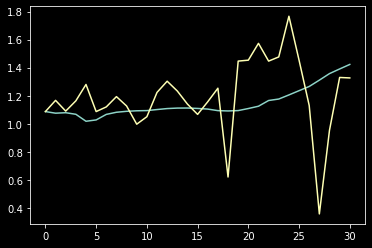

In [214]:
from matplotlib import pyplot as plt

plt.plot(np.arange(31), y_approx_actual[1, -1, :])
plt.plot(np.arange(31), true1[1, -1, :])

In [218]:
y_approx_actual = torch.zeros(pred1.shape) 
y_approx_actual[0, :, :] = pred1[0, :, :] * (y_max[0] - y_min[0]) + y_min[0]
y_approx_actual[2, :, :] = pred1[2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 
y_approx_actual[1, :, :] = pred1[1, :, :]
true2 = torch.zeros(pred1.shape)           
true2[0, :, :] = true1[0, :, :] * (y_max[0] - y_min[0]) + y_min[0]
true2[2, :, :] = true1[2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 
true2[1, :, :] = true1[1, :, :]

In [219]:
criterion(y_approx_actual, true2)

tensor(27.5976)

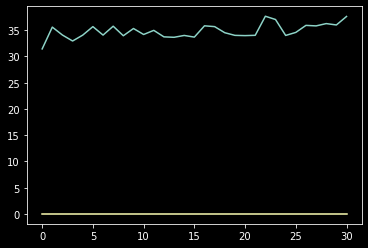

In [196]:
from matplotlib import pyplot as plt

plt.plot(np.arange(31), y_approx_actual[2, -1, :])
plt.plot(np.arange(31), true2[2, -1, :])

In [104]:
import time

num_epoch = 100 

for epoch in range(1, num_epoch + 1): 
    start = time.time()
    train_loss = train_LWR(model, train_loader, optimizer, criterion)[-1]
    train_losses.append(train_loss)
    _, _, val_loss, best_loss = val_LWR(model, val_loader, best_loss, criterion, name) 
    val_losses.append(val_loss)
    if val_loss <= best_loss: 
        best_loss = val_loss
        best_model = model
    if not train_loss: 
        break
    best_loss = best_loss
    end = time.time()
    print(f"Epoch: {epoch} completed in: {end - start}s. Training loss: {train_loss}. Val loss: {val_loss}") 
    
    scheduler.step() 
    if epoch % 5 == 0: print(optimizer.param_groups[0]['lr'])

1.1825866041315147
2.1805876200365817
2.2544744935828556
1.200299223041716
1.7235563641323448
3.191055569979845
1.2117445151962645
1.2320452638475774
1.6200639364319651
1.880740912006517
0.8885461628839854
0.9041222628382924
1.2889925091443255
1.1961335448524055
2.977897016241783
3.4422598901325747
1.4353516973707385
0.9279249119158416
0.860420418306171
0.9988475690896321
1.0783064015042039
0.832288977924759
2.651510287936724
0.8476558173802347
2.8345168272422683
3.361307101880547
1.2051734788707604
2.596150102452994
1.0245869053069891
1.0224236186652575
0.9787413797921174
2.350324462241945
3.0934969750944767
1.0703982943344355
3.3024733856704582
3.121609475011518
1.0286158926661777
Epoch: 1 completed in: 65.71229314804077s. Training loss: 1.7566818883551025. Val loss: 1.3782603176840038
1.3572039791862414
0.958520011797032
0.9392189321686483
2.2767918515306227
1.1609149702910542
2.760684957049685
0.7991660735197006
1.9999810281248729
2.8412140525815843
0.9747956848533967
3.16783620317

0.6316459021384937
1.7484290535096991
0.5638227687177175
0.5642043025214662
0.5413869661824542
1.9331123189235564
1.9020071308745166
0.58607431933973
1.0431877862938184
0.9151459246857985
0.6079883937734589
0.5471438909553806
0.5101381666830299
0.778475917615532
1.8237053778346133
0.5758157360558792
1.6157915800881006
0.5437455444692041
1.8382383533791302
1.5194493391852801
1.2204677945059663
1.4629190394469092
1.6692457182643325
0.5607666202407212
0.6821315049297428
0.570100163927973
1.0510790793802587
1.3059694536994484
1.1505987587041782
Epoch: 11 completed in: 67.82635951042175s. Training loss: 0.9462216543280764. Val loss: 0.7664447965146609
0.7564922043544355
1.8169989023567088
1.5117515055848378
1.4869014027411533
1.1565038115884327
0.6143867169107453
0.6200681458101654
0.6049508180173201
0.6154433856451237
1.8014155944950137
1.2307504879083044
0.5516238791109462
1.5706241757906025
0.6013295621515613
1.602964235121999
0.5749592648565871
0.6223965495619366
0.9523699441526111
1.30

1.5022137363767942
0.8792011650865017
1.3692200701154986
0.49836406699171854
1.5998145328659532
0.4661265359133661
0.5822035492944655
1.2541324551855817
1.6596084725085052
1.7118528399071942
0.6685555336964308
0.9842813614424833
0.488956163080723
0.5043322849369056
0.4984578900835181
1.435923288352764
0.5090958474996818
1.323649583765131
1.7071968447824182
0.5535324129433521
0.5166236066906592
1.6021873524817891
0.4887926687095254
0.6023794870676995
Epoch: 21 completed in: 61.88628888130188s. Training loss: 0.8544197038979956. Val loss: 0.6898920064173267
0.5780157445354338
1.6962330209450283
0.49686191622605513
0.5551324018668626
0.7822039837682666
0.5547975506178495
1.4193334372288209
0.9712874878505025
1.2070107584699303
0.7085746422872261
0.5224121789137247
0.5194308771613231
0.4764506357586556
1.5900806205237539
0.5206932978477925
0.5573773962685575
1.2959833401518337
0.6079418140639524
0.5075429842198117
0.5150327785083058
0.9796305597413985
0.53017668332859
1.4631634894884396
0.

0.4764722234274427
0.5176350229300837
1.6681026958347402
0.5602316333606887
0.4625214249633027
1.5618490584508748
0.5255384176962672
1.3161780793170323
0.9765756323357478
0.7322019986184108
0.4643440999973185
0.48479825851069297
0.9244642160482394
1.588851724651262
1.2125495907354285
1.4138536409388827
1.4152282059259933
0.4564773417783248
0.4891441790835458
0.4828979097502674
0.5083082999265853
Epoch: 31 completed in: 66.44411587715149s. Training loss: 0.8213041382306084. Val loss: 0.6634724913215398
0.9638929113472452
0.5711485899555696
1.084474961836763
0.4810359222256176
0.6997147827440674
0.6466528341868855
0.48645382065441384
1.2902734674058516
1.2555150572363025
0.9248343621228731
0.4974630191305037
0.7393335591828599
0.532705558084135
0.4541457100199017
1.4977919013914642
0.4705314602222232
0.49203926874512766
0.5074584713626465
0.47474778391621536
1.568743308772774
0.48891492481839566
1.4003697054983872
1.650291654907737
0.4915885299183204
1.54382620477859
0.4873972416650036
0

0.513764117608718
0.5161584723561085
0.4529111714676931
0.9015824370736312
1.6187779286597803
1.2030103499834717
0.4717674697638283
0.8112651188919741
0.5499090750542613
0.4720463962523231
1.3930628517447299
1.3029766493252806
0.4426609843770364
1.2373655090005882
0.4724013884198141
1.506864856503985
1.534289890890052
0.45535835220089577
1.567793486845777
Epoch: 41 completed in: 67.74839925765991s. Training loss: 0.8068860781376701. Val loss: 0.6489075690276656
0.6966510548508108
1.234799168750786
0.4741660473076159
0.45404074628900676
1.0870153890313683
0.47754393476731055
0.4449990037456638
0.627430434419301
0.9001553758559909
1.385793649540595
0.5138049725202446
0.4596192524106118
0.47541443453364784
1.6100443620206293
0.47758146567630205
0.5536713725144261
0.4756130898707714
0.46507562539188013
1.5615702050255074
0.4915000914594452
0.7160726186164287
0.4623283084470779
0.4503458189969897
1.5302576586832708
1.503091079949525
1.4019160207283838
0.5134491080986825
0.46372416945707506


0.8902017711917517
1.0832277699122517
1.6245337280890628
0.4675358165124934
1.3746946209420883
0.43675634598968
0.960611612915785
0.48431918178242783
1.2206662347768256
0.6180824038693582
0.6907845035184447
0.44378548959072794
1.28748341988186
0.46518016062958806
0.42808592347184665
0.4488562114360417
1.5514597390882527
1.3872248593328813
Epoch: 51 completed in: 67.15975856781006s. Training loss: 0.7974345492917252. Val loss: 0.6420850368115729
0.4654452792644451
0.8896315920438566
1.3731428364895206
0.4579746105312909
0.6900612322806976
0.4850404792158256
0.4719400814384375
1.219246313765705
0.9584715867597282
0.6194967649160263
0.43714592194636964
1.6203000734547905
1.2831372833620238
0.4677738623034947
0.46982777120638214
0.5481044622852511
0.44718296482354253
0.5083569014704723
0.4451528040777483
1.189220125264347
1.4822634222784083
0.5503402916709725
0.46421767211408943
0.5073354380494176
1.0793283664564504
0.5078784278361126
0.4292359679917714
1.597151815943148
0.4642058281232397

0.8000630248980093
0.47299755896291534
0.4760238873219013
1.3667371169180327
1.0694574043840208
0.4284548164028104
0.44588276862981857
0.47045257907602694
0.4849755337022592
0.46821472830529587
0.4577191425095317
0.44987155671525125
0.8853810240709029
1.3596738186490065
0.7101898169250257
0.4667001754519144
Epoch: 61 completed in: 65.39754486083984s. Training loss: 0.7922717918923506. Val loss: 0.639665541495892
0.4597317629601539
0.43455915068482376
0.5060419251664482
0.47374469696728594
1.1800735079743123
0.4559597222600738
1.0730181919519375
0.6850629002973184
0.7083604532451897
1.5351287249468755
1.500245902602329
0.466956369438732
1.2729503885065756
0.4649297274535388
0.546609449678985
0.8849206793589449
0.44760432453611104
0.46263737393481297
0.42611364576973443
1.210280824468518
0.4651527782539276
0.7988610791562977
0.44379283074812453
0.6178921598438669
0.4823316473926338
0.5454466551973263
0.4622287331644581
0.9531752832916685
0.5042302149171504
0.5039581053003627
1.3766374481

1.3659710438564505
0.7067548125533106
0.5070508861940124
0.47342942851215186
1.3552181216223924
0.4250053983904225
0.4548375811476623
0.47064429369246324
0.46483831862067776
0.4579606678489904
0.4463137298436719
0.43230970353602627
0.4661986087842341
0.5457345541686229
Epoch: 71 completed in: 61.63775014877319s. Training loss: 0.7894515165450825. Val loss: 0.6370602495130953
1.3662652177797867
0.45420362431518946
0.4454648057094892
1.1773863238386364
0.4420677747173193
0.4651265547649887
0.46842703717980555
0.881304020227995
1.2057992194566447
0.5028809786402799
1.0713980546765471
1.5828829668927733
0.5449482189838755
1.6037867566158008
0.7956485415603709
1.3566283297638642
1.2698133975428854
0.48080256758046164
0.46055485285151604
0.6830893841184321
0.4238819673571647
0.5450484062309741
0.7059951931431343
0.4632951813089149
0.4401357700414209
0.4717427403924678
0.6159791371301029
1.5301910049685086
0.5033258555023314
0.5047964747942559
0.46210971870147005
0.9502422273793322
0.46178334

0.6831236628798157
0.45978780910784467
0.4784669424443959
1.6039159307286304
0.43957711312068243
0.5441146135075446
0.4522441070176991
1.4690745309806814
1.2719319127352635
0.7929387354747349
0.5014140266975338
1.3555885512731687
1.4943054333510608
Epoch: 81 completed in: 61.86407685279846s. Training loss: 0.7872520222874048. Val loss: 0.634775638229679
0.5004497867654155
0.46136166580647675
0.5015493723908878
0.4513872021199799
0.7026177979665307
1.2041563574475018
0.4782337243771691
0.6123911482504036
1.5328450992319835
0.45205490365247775
1.6042377403012869
1.3703325125107042
0.4366420278654445
1.072820409950974
1.4940846315096084
0.8786269883167007
0.42048103468051223
0.45934903994135695
0.441889033898327
0.5010050953232439
0.9506924038074057
0.45982148284355234
1.1795023277106969
1.5827653535730883
0.4296882980583984
0.45959653861285943
0.5412655929152546
0.6830197300826855
1.3547804952707307
1.4677978534399585
0.7929513858984881
1.270585978220117
0.4397830825500324
0.468906199721

0.9498738794271523
1.1783115271964673
0.4592328652399425
0.4646704466406141
0.7019854061177123
0.6122300088759498
1.6009631922929437
0.500582767703693
0.5407810136819197
0.45227605918906355
1.4661634972682747
0.5015825742039408
Epoch: 91 completed in: 61.81709933280945s. Training loss: 0.7862232064582826. Val loss: 0.6341238751500959
0.45886312185124173
0.4999870307145069
0.46453289471410897
0.45926886606487927
0.8773654117443259
0.44104708304919793
1.4917826855961969
1.2702929816095967
0.7917222542844778
0.45177989209260844
1.202213924731368
0.46762284720334024
0.419682636811936
1.601793466800897
0.5002265389041652
0.43599707235373186
0.4288467151943909
1.5816834853907955
1.5306365516231115
0.6115568777868958
0.5435449506361074
0.450673770509465
0.9502298088453158
0.47766399281926514
1.3682860281819669
0.7015339699435382
0.5401881616707029
0.4388316138561938
1.3531749137399243
1.4670199264297317
1.071629769270536
0.4589539982347701
1.178442623977328
0.5012668818567897
0.45635743256635

In [105]:
_, _, val_loss, best_loss = val_LWR(best_model, val_loader, best_loss, criterion, name) 

In [106]:
val_loss

0.6335629356537513

In [107]:
_, _, test_loss, best_loss = val_LWR(best_model, test_loader, best_loss, criterion, name)

In [108]:
test_loss

0.5162724959519308

In [20]:
import time

num_epoch = 100 

for epoch in range(1, num_epoch + 1): 
    start = time.time()
    train_loss = train(model, train_loader, optimizer, criterion)[-1]
    train_losses.append(train_loss)
    _, _, val_loss, best_loss = val(model, val_loader, best_loss, criterion, name) 
    val_losses.append(val_loss)
    best_loss = best_loss
    end = time.time()
    print(f"Epoch: {epoch} completed in: {end - start}s. Training loss: {train_loss}. Val loss: {val_loss}") 
    
    scheduler.step() 
    if epoch % 5 == 0: print(optimizer.param_groups[0]['lr'])

running batch 0
running batch 2
Epoch: 1 completed in: 3.1080243587493896s. Training loss: 1.947865108648936. Val loss: 0.40356836915016175
running batch 0
running batch 2
Epoch: 2 completed in: 2.138023853302002s. Training loss: 0.6002517342567444. Val loss: 0.4358689248561859
running batch 0
running batch 2
Epoch: 3 completed in: 8.119099378585815s. Training loss: 0.4161071181297302. Val loss: 0.2977495759725571
running batch 0
running batch 2
Epoch: 4 completed in: 10.784952163696289s. Training loss: 0.3376070459683736. Val loss: 0.28859650492668154
running batch 0
running batch 2
Epoch: 5 completed in: 10.362762451171875s. Training loss: 0.33840180436770123. Val loss: 0.27523312866687777
0.007737809374999999
running batch 0
running batch 2
Epoch: 6 completed in: 17.845856428146362s. Training loss: 0.29849464694658917. Val loss: 0.2764220893383026
running batch 0
running batch 2
Epoch: 7 completed in: 21.38545036315918s. Training loss: 0.2918436676263809. Val loss: 0.296846374869346

Epoch: 57 completed in: 66.17486548423767s. Training loss: 0.08949837585290273. Val loss: 0.0941287860274315
running batch 0
running batch 2
Epoch: 58 completed in: 65.39003658294678s. Training loss: 0.0894229883948962. Val loss: 0.09426508545875549
running batch 0
running batch 2
Epoch: 59 completed in: 66.74050784111023s. Training loss: 0.08699657519658406. Val loss: 0.09434488266706467
running batch 0
running batch 2
Epoch: 60 completed in: 65.12764954566956s. Training loss: 0.08672854801019032. Val loss: 0.0938887968659401
0.00046069798986951934
running batch 0
running batch 2
Epoch: 61 completed in: 67.29894256591797s. Training loss: 0.08619315425554912. Val loss: 0.09369097799062728
running batch 0
running batch 2
Epoch: 62 completed in: 66.78678011894226s. Training loss: 0.08631102989117305. Val loss: 0.0929329439997673
running batch 0
running batch 2
Epoch: 63 completed in: 67.15861797332764s. Training loss: 0.08438699195782344. Val loss: 0.09257390201091767
running batch 0
run

In [23]:
_, _, val_loss, best_loss = val_true(model, val_loader, best_loss, criterion, name) 

In [24]:
val_loss

0.11665502041578293

In [25]:
_, _, test_loss, best_loss = val_true(model, test_loader, best_loss, criterion, name) 

In [26]:
test_loss

0.10998494476079941

In [50]:
import time

num_epoch = 100 

for epoch in range(1, num_epoch + 1): 
    start = time.time()
    train_loss = train(model, train_loader, optimizer, criterion)[-1]
    train_losses.append(train_loss)
    _, _, val_loss, best_loss = val(model, val_loader, best_loss, criterion, name) 
    val_losses.append(val_loss)
    best_loss = best_loss
    end = time.time()
    print(f"Epoch: {epoch} completed in: {end - start}s. Training loss: {train_loss}. Val loss: {val_loss}") 
    
    scheduler.step() 
    if epoch % 5 == 0: print(optimizer.param_groups[0]['lr'])

Epoch: 1 completed in: 2.4267256259918213s. Training loss: 1.4755058288574219. Val loss: 0.5719267070293427
Epoch: 2 completed in: 0.04641604423522949s. Training loss: 0.5523438652356466. Val loss: 0.7528448164463043
Epoch: 3 completed in: 0.04623985290527344s. Training loss: 0.5979651908079783. Val loss: 0.5621711850166321
Epoch: 4 completed in: 0.046727657318115234s. Training loss: 0.42438923319180805. Val loss: 0.3805052250623703
Epoch: 5 completed in: 0.04590868949890137s. Training loss: 0.3338751494884491. Val loss: 0.36281355619430544
0.007737809374999999
Epoch: 6 completed in: 0.04886674880981445s. Training loss: 0.3087157905101776. Val loss: 0.3499125450849533
Epoch: 7 completed in: 0.04787468910217285s. Training loss: 0.34818823138872784. Val loss: 0.3419408410787582
Epoch: 8 completed in: 0.04584646224975586s. Training loss: 0.31313590208689374. Val loss: 0.3408444494009018
Epoch: 9 completed in: 0.048900604248046875s. Training loss: 0.3251766562461853. Val loss: 0.3504711985

Epoch: 75 completed in: 0.04868030548095703s. Training loss: 0.3121125251054764. Val loss: 0.3310615122318268
0.00021343733845877503
Epoch: 76 completed in: 0.04801750183105469s. Training loss: 0.3020532230536143. Val loss: 0.3302141189575195
Epoch: 77 completed in: 0.04591870307922363s. Training loss: 0.30699789027373. Val loss: 0.3300092935562134
Epoch: 78 completed in: 0.045868873596191406s. Training loss: 0.3120117286841075. Val loss: 0.32992863953113555
Epoch: 79 completed in: 0.04983329772949219s. Training loss: 0.2872232099374135. Val loss: 0.3299028486013412
Epoch: 80 completed in: 0.047902822494506836s. Training loss: 0.31062453985214233. Val loss: 0.3297282844781876
0.00016515374385013573
Epoch: 81 completed in: 0.04786944389343262s. Training loss: 0.2915903925895691. Val loss: 0.3295227974653244
Epoch: 82 completed in: 0.04485130310058594s. Training loss: 0.30861610174179077. Val loss: 0.329474139213562
Epoch: 83 completed in: 0.04591083526611328s. Training loss: 0.303363223

In [22]:
def val_true(model, val_loader, best_loss, criterion, name): 
    preds = []
    trues = []
    mse = []
    
    model.eval()
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            pred = model(X, 12)
            pred[:, 0, :, :] = (pred[:, 0, :, :] * std[0] + mean[0])
            pred[:, 1, :, :] = (pred[:, 1, :, :] * std[1] + mean[1])
            pred[:, 2, :, :] = (pred[:, 2, :, :] * std[2] + mean[2])
                                
            y[:, 0, :, :] = (y[:, 0, :, :] * std[0] + mean[0])
            y[:, 1, :, :] = (y[:, 1, :, :] * std[1] + mean[1])
            y[:, 2, :, :] = (y[:, 2, :, :] * std[2] + mean[2])
            loss = 0
            loss = criterion(pred, y)
            mse.append(loss.item()) 
            
            trues.append(y.cpu().data.numpy())
            preds.append(pred.cpu().data.numpy())

        preds = np.concatenate(preds, axis = 0)
        trues = np.concatenate(trues, axis = 0)
    
    val_loss = np.mean(mse)


    return preds, trues, val_loss, best_loss

In [54]:
_, _, val_loss, best_loss = val_true(model, val_loader, best_loss, criterion, name) 

In [55]:
val_loss

0.7206501841545105

In [52]:
_, _, test_loss, best_loss = val_true(model, test_loader, best_loss, criterion, name) 

In [53]:
test_loss

0.4989096105098724

In [59]:
import time

num_epoch = 100 

for epoch in range(1, num_epoch + 1): 
    start = time.time()
    train_loss = train(model, train_loader, optimizer, criterion)[-1]
    train_losses.append(train_loss)
    _, _, val_loss, best_loss = val(model, val_loader, best_loss, criterion, name) 
    val_losses.append(val_loss)
    best_loss = best_loss
    end = time.time()
    print(f"Epoch: {epoch} completed in: {end - start}s. Training loss: {train_loss}. Val loss: {val_loss}") 
    
    scheduler.step() 
    if epoch % 5 == 0: print(optimizer.param_groups[0]['lr'])

Epoch: 1 completed in: 0.07480025291442871s. Training loss: 1.0905334949493408. Val loss: 1.1035150170326233
Epoch: 2 completed in: 0.06187725067138672s. Training loss: 0.9779378573099772. Val loss: 0.9753333687782287
Epoch: 3 completed in: 0.055965423583984375s. Training loss: 0.972327450911204. Val loss: 0.9973872303962708
Epoch: 4 completed in: 0.05385613441467285s. Training loss: 0.9110895196596781. Val loss: 0.9508996725082397
Epoch: 5 completed in: 0.061803340911865234s. Training loss: 0.8661429484685262. Val loss: 0.9353342294692993
0.007737809374999999
Epoch: 6 completed in: 0.06283140182495117s. Training loss: 0.8311317165692648. Val loss: 0.9281793117523194
Epoch: 7 completed in: 0.06582450866699219s. Training loss: 0.8462584614753723. Val loss: 0.9215965747833252
Epoch: 8 completed in: 0.06283307075500488s. Training loss: 0.8129909634590149. Val loss: 0.9240532040596008
Epoch: 9 completed in: 0.06781792640686035s. Training loss: 0.8303490479787191. Val loss: 0.92125235795974

Epoch: 73 completed in: 0.05689072608947754s. Training loss: 0.7711352507273356. Val loss: 0.896590507030487
Epoch: 74 completed in: 0.05488467216491699s. Training loss: 0.7761260271072388. Val loss: 0.8965644836425781
Epoch: 75 completed in: 0.053824424743652344s. Training loss: 0.7529723048210144. Val loss: 0.8965376019477844
0.00021343733845877503
Epoch: 76 completed in: 0.05587649345397949s. Training loss: 0.7993989984194437. Val loss: 0.8965210437774658
Epoch: 77 completed in: 0.05781984329223633s. Training loss: 0.8164159258206686. Val loss: 0.896517527103424
Epoch: 78 completed in: 0.06582474708557129s. Training loss: 0.7853730320930481. Val loss: 0.8964978456497192
Epoch: 79 completed in: 0.06382894515991211s. Training loss: 0.7436046401659647. Val loss: 0.8964777588844299
Epoch: 80 completed in: 0.06283187866210938s. Training loss: 0.7928550640741984. Val loss: 0.8964643597602844
0.00016515374385013573
Epoch: 81 completed in: 0.05787944793701172s. Training loss: 0.766018311182

In [60]:
_, _, val_loss, best_loss = val_true(model, val_loader, best_loss, criterion, name) 

In [61]:
val_loss

2.5083229303359986

In [62]:
_, _, test_loss, best_loss = val_true(model, test_loader, best_loss, criterion, name) 

In [63]:
test_loss

1.1947527647018432

In [79]:
#torch.optim.lr_scheduler.StepLR?
#torch.optim.SGD?

In [80]:
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(tdnu.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95) #0.95 #step_size=1
#torch.optim.lr_scheduler.StepLR?

- reduce time step $\Delta t$
- try different optimizer
- reduce learning rate decay (step_size in scheduler) - 500 epochs

In [81]:
num_epochs = 100
loss_fun = torch.nn.MSELoss()
min_loss = 10

In [82]:
y_approx = seq2seq(y_norm[:, 0:67], 66)
print(y_norm[:, 1:67].shape, y_approx.shape)

torch.Size([3, 66, 31]) torch.Size([3, 66, 31])


In [83]:
print(y_approx.shape, y_norm.shape)
loss=loss_fun(y_approx, y_norm[:, 1:67, :])
#torch.cat(tdn.k, dim=1).shape
#torch.cat([torch.tensor(p) for p in tdn.k], dim=1).shape
print("Initial loss: %e" % loss)
loss_history=[loss.item()]

torch.Size([3, 66, 31]) torch.Size([3, 71, 31])
Initial loss: 3.678728e-01


In [84]:
## loss without normalization 
y_approx_actual = torch.zeros(y_approx.shape) 
y_approx_actual[0, :, :] = y_approx[0, :, :] * (y_max[0] - y_min[0]) + y_min[0]
y_approx_actual[1, :, :] = y_approx[1, :, :] * (y_max[1] - y_min[1]) + y_min[1]
y_approx_actual[2, :, :] = y_approx[2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 

loss=loss_fun(y_approx_actual, y_exact[:, 1:67, :]) 
print("Initial actual loss: %e" % loss)

Initial actual loss: 4.887751e+01


In [85]:
history=[]
tqdm_epochs = tqdm(range(num_epochs))
for e in tqdm_epochs:
    y_approx = seq2seq(y_norm[:, 0:67], 66)
    loss = loss_fun(y_approx, y_norm[:, 1:67, :])
    loss_history.append(loss.item())
    if loss.item() < min_loss:
        best_model_seq = seq2seq
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    history.append(loss.item())
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()}) 
    
    scheduler.step() 

100%|██████████| 100/100 [00:04<00:00, 24.55it/s, loss=0.00748]


In [86]:
## loss without normalization 
y_approx_actual = torch.zeros(y_approx.shape) 
y_approx_actual[0, :, :] = y_approx[0, :, :] * (y_max[0] - y_min[0]) + y_min[0]
y_approx_actual[1, :, :] = y_approx[1, :, :] * (y_max[1] - y_min[1]) + y_min[1]
y_approx_actual[2, :, :] = y_approx[2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 

loss=loss_fun(y_approx_actual, y_exact[:, 1:67, :]) 
print("Initial actual loss: %e" % loss)

Initial actual loss: 5.084043e-01


In [87]:
xi = [0, 4, 12, 22, 32, 39, 46, 50, 54, 57, 59, 63, 66, 69, 71, 74, 76, 81, 84, 86, 89, 91, 95, 96, 98, 100, 102, 105, 108, 110, 112]

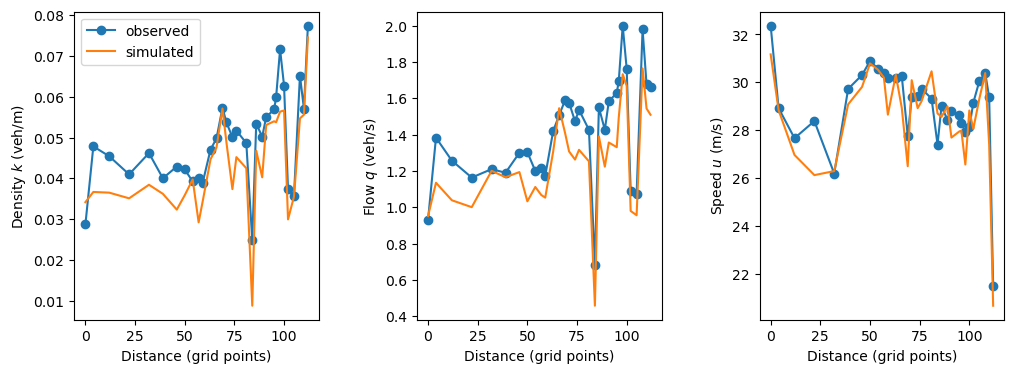

In [88]:
tp=1
#print(y_approx[tp])
#print(y_exact[tp])
plt.style.use('default')
fig3,ax3=plt.subplots(ncols=3, nrows=1, figsize=(12,4))
fig3.subplots_adjust(wspace=0.4)

varplot={0: y_approx_actual[0, :, :], 1: y_approx_actual[1, :, :], 2: y_approx_actual[2, :, :]}
label={0: "Density $k$ (veh/m)",
       1: "Flow $q$ (veh/s)",
       2: "Speed $u$ (m/s)"}
for n in range(3):
    ax3[n].plot(xi, y_exact[n,1,:].detach(), label='observed', marker='o')
    if n==1: 
        ax3[n].plot(xi, varplot[n][0].detach(), label='simulated') 
    else: 
        ax3[n].plot(xi, varplot[n][0].detach(), label='simulated')
    #print(k_boundary[tp*tskip])
    if n==0:
        ax3[n].legend()
    ax3[n].set_xlabel("Distance (grid points)")
    ax3[n].set_ylabel(label[n])
#ax3.set_ylim(0, 0.3)
fig3.savefig("kqu_parstep10.png", dpi=300)

In [89]:
y_predicted = seq2seq(y_norm[:, 67:, :], 3).detach()

In [90]:
## re-transform: testing loss without normalization (used for comparison)
y_predicted_actual = torch.zeros(y_predicted.shape) 
y_predicted_actual[0, :, :] = y_predicted[0, :, :] * (y_max[0] - y_min[0]) + y_min[0]
y_predicted_actual[1, :, :] = y_predicted[1, :, :] * (y_max[1] - y_min[1]) + y_min[1]
y_predicted_actual[2, :, :] = y_predicted[2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 

loss=loss_fun(y_predicted_actual, y_exact[:, 68:, :]) 
print("Final actual loss: %e" % loss) 

Final actual loss: 7.261999e-01


In [22]:
y_predicted.shape

torch.Size([3, 3, 31])

In [25]:
import json

station_names=list(json.load(open("5S_station_names.json", "rb")).values())
record_times=json.load(open("5S_record_times.json", "r"))
#record_times

FileNotFoundError: [Errno 2] No such file or directory: '5S_record_times.json'

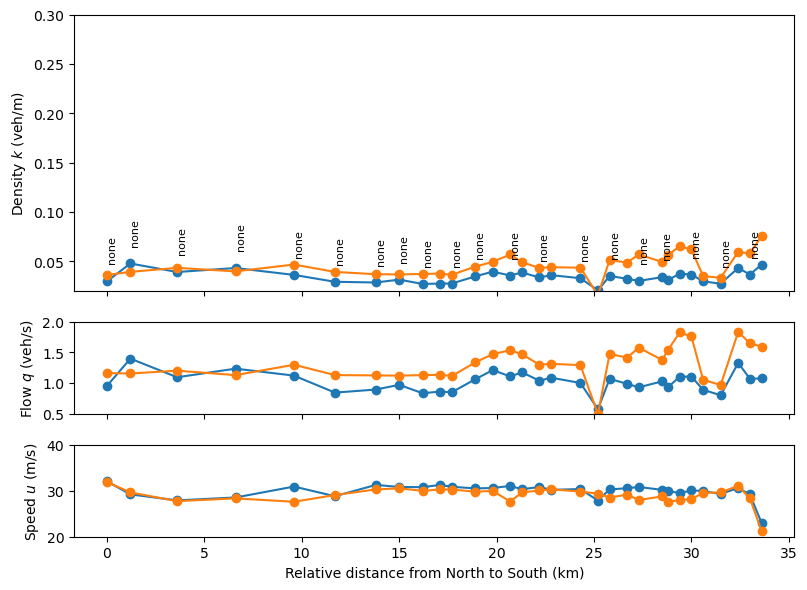

In [91]:
tp=70
plt.style.use('default')

from matplotlib import gridspec

fwyp=[xi[n]* 300 / 1.e3 for n in range(len(xi))]

#gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1]) 
gs_kw={"height_ratios": [3, 1, 1]}

fig4,ax4=plt.subplots(figsize=(8,6), nrows=3, gridspec_kw=gs_kw, sharex=True)
fig4.subplots_adjust(left=0.08, bottom=0.08, right=0.98, top=0.95)
ymin=[0.02, 0.5, 20]
ymax=[0.30, 2.0, 40]

for n in range(3): 
    ax4[n].plot(fwyp, (y_norm[n, tp, :] * (y_max[n] - y_min[n]) + y_min[n]).cpu().detach(), label='observed', marker='o')
    ax4[n].plot(fwyp, (y_predicted[n, tp-68, :] * (y_max[n] - y_min[n]) + y_min[n]).cpu().detach(), label='predicted', marker='o')
        
    ax4[n].set_ylim(ymin[n], ymax[n])
    #ax4[n].set_xlabel("Distance (grid points)")
    ax4[n].set_ylabel(label[n])

    #ax4[n].set_xlim(fwyp[0]-1, fwyp[-1]+1)

    lastpoint=-100
    if n==0:
        for p in range(len(xi)):
            if (fwyp[p] - lastpoint) > 1.:
                ax4[n].text(fwyp[p], (y_norm[n, tp, :] * (y_max[n] - y_min[n]) + y_min[n]).detach()[p] + 0.02, "none", rotation=90, fontsize=8)
                lastpoint=fwyp[p]
    
ax4[2].set_xlabel("Relative distance from North to South (km)")
#ax4[n].set_ylabel("Traffic density (Veh/m)")
fig4.savefig('LWR_prediction_5S.jpg', dpi=300)